<a href="https://colab.research.google.com/github/davidrtorres/Deep_Learning/blob/main/images_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Augmentation
This is an image binary classification problem using convolutional neural networks (CNN) to detect whether images of malarial cells are parasitized or healthy.  The dataset consists of 2 folders of Parasitized and Uninfected images. The Parasitized folder contains 13,799 images. The Unifected folder also contains 13,799 images.  

I used the ImageDataGenerator so I needed to create train and validation sets from the dataset.  I used the split-folders library which resulted in creating train and validation with 80% and 20% of the dataset.  The ImageDataGenerator class allows the users to perform image augmentation while training the model.  Data augmentation allows you to generate new samples from existing training samples.  With data augmentation, from an image we can apply several transformations such as horizontal flip, rotation, scaling, contrast, zoom.  This also you to generate new samples of the image.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL #Python image library
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import models, layers
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization

In [3]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders

### Split Dataset into Train and Validation Sets

In [5]:
#validation data is used as part of the training but only to validate after each epoch and report metrics after each epoch using vlidation data
#test set doesn't get used as part of the training.  To test completely trained model on the test data
"""
input_folder = "/path/to/input/folder"
output = "/path/to/output/folder" #where you want the split datasets saved. one will be created if it does not exist or none is set

split_folders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. For train/val sets only do .75, .25 .

"""
input_folder = "/content/drive/MyDrive/datasets/cell_images/"

splitfolders.ratio(input_folder, output="/content/drive/MyDrive/datasets/cell_images2",seed=42, ratio=(.80,.20), group_prefix=None)

Copying files: 27560 files [3:21:01,  2.28 files/s]


### Create Convolutional Neural Network Model

In [6]:
BATCH_SIZE = 32
SIZE = 150
CHANNELS=3

In [7]:
INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3). Images input into network


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))#puts a 2 x 2 matrix on top of previous image. In matrix pulling maximum #.
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.2))#droput 20% of data radomnly, way of regularizing algorithm to avoid overfittin or minimize it.

model.add(Conv2D(32, (3, 3))) #, kernel_initializer = 'he_uniform'
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(64, (3, 3))) #, kernel_initializer = 'he_uniform'
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.2))

#flatten layer
model.add(Flatten())
#hidden layer
model.add(Dense(256, activation='relu'))
#model.add(Activation('relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
#output layer
model.add(Dense(1, activation='sigmoid'))


#loss function we're trying to minimize after every epoch
model.compile(loss='binary_crossentropy',#categorical_crossentropy
              optimizer='adam',            #also try rmsprop'
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9

In [8]:
#above defined the model
#Next, fit the training data to the model
#train a data generator using ImageDataGenerator
#want to generate training data

batch_size=16

#training data generator
#this defines how train_datagen is going to generate the augmented images 
train_datagen = ImageDataGenerator(
  rescale = 1./255,#rescale inputs, inputs converting are unsigned integer 8 into floating points number
  rotation_range=45,
  shear_range=0.2,
  zoom_range=0.2,  
  horizontal_flip=True
)

#validation generator
#not generating any augmented images with this
#just rescaling
validation_datagen = ImageDataGenerator(
  rescale = 1./255) #rescale inputs, inputs converting are unsigned integer 8 into floating points number

In [9]:
#this reads the data
train_generator = train_datagen.flow_from_directory(
  '/content/drive/MyDrive/datasets/cell_images2/train/',  
  target_size=(150,150),
  batch_size=batch_size,
  class_mode='binary')  

validation_generator = validation_datagen.flow_from_directory(
  "/content/drive/MyDrive/datasets/cell_images2/val/",                                   
  target_size=(150,150),
  batch_size=batch_size,
  class_mode='binary')  #we're using binary_cross_entropy, this is a classification problem

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [10]:
#add checkpoints
from keras.callbacks import ModelCheckpoint

In [11]:
#if validation accuracy gets better it'd going to save that model
#"/content/drive/MyDrive/datasets/weights_improvements-{epoch:02d}-{val_acc:.2f}.hdf5"
#only saves it when it gets improved
filepath ="/content/drive/MyDrive/datasets/saved_models.hdf5"#save model after number many epochs
checkpoint = ModelCheckpoint(filepath,monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### Fit the Model

In [23]:
from keras import callbacks
#use generators to fit the model
#we have augmentation so use fit generator
#using data augmentation, the input file used for augmentation will never be passed into model.fit
#the augmented image is going to be part of the fit
history = model.fit_generator(
  train_generator,   
  steps_per_epoch= 2000 // batch_size,
  epochs=30,
  validation_data=validation_generator,
  validation_steps= 800 // batch_size
  #callbacks = callbacks_list
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


125/125 [==============================] - 25s 197ms/step - loss: 0.2194 - accuracy: 0.9235 - val_loss: 0.1625 - val_accuracy: 0.9450
Epoch 2/30
125/125 [==============================] - 24s 195ms/step - loss: 0.2073 - accuracy: 0.9305 - val_loss: 0.1842 - val_accuracy: 0.9438
Epoch 3/30
125/125 [==============================] - 24s 191ms/step - loss: 0.1931 - accuracy: 0.9370 - val_loss: 0.2004 - val_accuracy: 0.9325
Epoch 4/30
125/125 [==============================] - 24s 189ms/step - loss: 0.1963 - accuracy: 0.9355 - val_loss: 0.2073 - val_accuracy: 0.9388
Epoch 5/30
125/125 [==============================] - 23s 186ms/step - loss: 0.2133 - accuracy: 0.9290 - val_loss: 0.1943 - val_accuracy: 0.9262
Epoch 6/30
125/125 [==============================] - 24s 192ms/step - loss: 0.2058 - accuracy: 0.9270 - val_loss: 0.1936 - val_accuracy: 0.9312
Epoch 7/30
125/125 [==============================] - 24s 189ms/step - loss: 0.1996 - accuracy: 0.9360 - val_loss: 0.1702 - val_accuracy: 0.9

In [39]:
a = history.history
print(a)

{'loss': [0.21942809224128723, 0.20729707181453705, 0.1931491494178772, 0.19630222022533417, 0.21331307291984558, 0.20584194362163544, 0.19959785044193268, 0.19779041409492493, 0.20688273012638092, 0.20509345829486847, 0.18159356713294983, 0.20484071969985962, 0.18458068370819092, 0.18276195228099823, 0.21225008368492126, 0.20270611345767975, 0.20912304520606995, 0.19680239260196686, 0.2098885178565979, 0.22241045534610748, 0.19501174986362457, 0.21538013219833374, 0.22109468281269073, 0.20288924872875214, 0.18364861607551575, 0.18112915754318237, 0.19539639353752136, 0.22309666872024536, 0.21032343804836273, 0.2030661553144455], 'accuracy': [0.9235000014305115, 0.9304999709129333, 0.9369999766349792, 0.9355000257492065, 0.9290000200271606, 0.9269999861717224, 0.9359999895095825, 0.9369999766349792, 0.9275000095367432, 0.9325000047683716, 0.9369369149208069, 0.9355000257492065, 0.9380000233650208, 0.9365000128746033, 0.9275000095367432, 0.9290000200271606, 0.9359999895095825, 0.9304999

In [46]:
#how is model performing on training dataset and validation dataset
train_loss, train_acc = model.evaluate_generator(train_generator, steps=16)
test_loss, test_acc = model.evaluate_generator(validation_generator, steps=16)
print("Train: {}, Test:{}".format(train_acc, test_acc))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Train: 0.94140625, Test:0.9296875


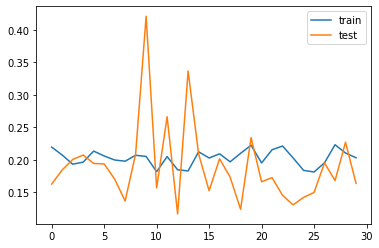

In [48]:
#plot training history for visual of how model performed
#test set isn't very stable
#doesn't seem to be converging very well
#which parameters to tune? If batch size too small not generalizing enough
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

### How to load saved Model and continue Training Process.

In [24]:
model.save("/content/drive/MyDrive/datasets/malaria_augmented.h5")

In [52]:
new_model = load_model("/content/drive/MyDrive/datasets/malaria_augmented.h5")

In [53]:
results = new_model.evaluate_generator(validation_generator, steps=16)
print("Validation loss and Accuracy are: {}".format(results))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Validation loss and Accuracy are: [0.16617050766944885, 0.93359375]


In [54]:
new_model.fit_generator(
  train_generator,   
  steps_per_epoch= 2000 // batch_size,
  epochs=50,
  validation_data=validation_generator,
  validation_steps= 800 // batch_size
  #callbacks = callbacks_list
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


125/125 [==============================] - 25s 192ms/step - loss: 0.1870 - accuracy: 0.9375 - val_loss: 0.2143 - val_accuracy: 0.9187
Epoch 2/50
125/125 [==============================] - 24s 190ms/step - loss: 0.1984 - accuracy: 0.9340 - val_loss: 0.1590 - val_accuracy: 0.9388
Epoch 3/50
125/125 [==============================] - 24s 191ms/step - loss: 0.1929 - accuracy: 0.9314 - val_loss: 0.1650 - val_accuracy: 0.9350
Epoch 4/50
125/125 [==============================] - 23s 185ms/step - loss: 0.1751 - accuracy: 0.9389 - val_loss: 0.1894 - val_accuracy: 0.9413
Epoch 5/50
125/125 [==============================] - 23s 186ms/step - loss: 0.2094 - accuracy: 0.9225 - val_loss: 0.1659 - val_accuracy: 0.9350
Epoch 6/50
125/125 [==============================] - 23s 185ms/step - loss: 0.1883 - accuracy: 0.9385 - val_loss: 0.1640 - val_accuracy: 0.9388
Epoch 7/50
125/125 [==============================] - 23s 186ms/step - loss: 0.1826 - accuracy: 0.9415 - val_loss: 0.1102 - val_accuracy: 0.9

In [55]:
new_model.save("/content/drive/MyDrive/datasets/malaria_augmented_updated.h5")

### Make Prediction on Two Images
Reading in 2 images one parasitized and the other uninfected.
Checking if the model correctly classifies the two images.

In [26]:
img1 = load_img("/content/drive/MyDrive/datasets/cell_images2/val/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png")
img2 = load_img("/content/drive/MyDrive/datasets/cell_images2/val/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_48.png")

In [27]:
# x1 = img_to_array(img1)
# x2 = img_to_array(img2)

In [28]:
 x1 = img1.resize((150,150))
 x2 = img2.resize((150,150))

In [29]:
x1 = img_to_array(x1)
x2 = img_to_array(x2)

In [30]:
x1 = x1.reshape((1,) +x1.shape)
x2 = x2.reshape((1,) + x2.shape)

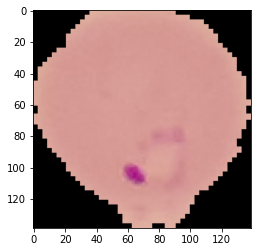

In [56]:
plt.imshow(img1)

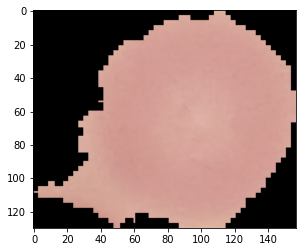

In [57]:
plt.imshow(img2)

In [32]:
X1 = model.predict(x1)
X2 = model.predict(x2)

In [33]:
print("Prediction for parasitized is: ", X1, "where 0 indicates parastizied and 1 indicates uninfected")
print("Prediction for uninfected is: ", X2, "where 0 indicates parastizied and 1 indicates uninfected")

Prediction for parasitized is:  [[0.]] where 0 indicates parastizied and 1 indicates uninfected
Prediction for uninfected is:  [[1.1066514e-20]] where 0 indicates parastizied and 1 indicates uninfected
